# ACE estimations from real observational data
*This notebook examines the use of the `CausalEffectEstimation` module for estimating Average Causal Effects (ACE) in Observational Studies from real data:* 

In [68]:
import pyAgrum as gum
import pyAgrum.skbn.discretizer as disc
import pyAgrum.lib.explain as gexpl
import pyAgrum.lib.notebook as gnb

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import pandas as pd

pd.set_option('future.no_silent_downcasting', True)

### Dataset
The dataset under consideration is the Census Adult Income dataset.
The objective of this analysis is to determine whether possessing a graduate degree increases the likelihood of earning an income exceeding $50,000 per year.

In [69]:
df = pd.read_pickle("../data/df_causal_discovery.p")
df.head()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0


In [70]:
df.describe()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
count,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000
mean,38.655674,40.447755,0.052348,0.406616,0.878334,0.331916,0.245835
std,13.722408,12.417203,0.222732,0.491211,0.326905,0.470909,0.430588
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,45.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,90.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Preparation and Setup
We begin by focusing exclusively on the age covariate to inform our estimations. We hypothesize that age is a causal factor influencing both the hasGraduateDegree variable and the greaterThan50k outcome.

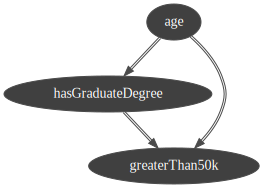

In [71]:
discretizer = disc.Discretizer(defaultDiscretizationMethod="NoDiscretization", defaultNumberOfBins=None)
template = discretizer.discretizedTemplate(df[["age", "hasGraduateDegree", "greaterThan50k"]])
template.addArcs([("age","hasGraduateDegree"), ("age", "greaterThan50k"), ("hasGraduateDegree", "greaterThan50k")])

causal_model = csl.CausalModel(template)

cslnb.showCausalModel(causal_model, size="50")

In [72]:
T = "hasGraduateDegree"
Y = "greaterThan50k"
X = "age"

In [73]:
cee = csl.CausalEffectEstimation(df, causal_model)

In [74]:
cee.identifyAdjustmentSet(intervention=T, outcome=Y)

Backdoor adjustment found. 

Supported estimators include:
- CausalModelEstimator
- SLearner
- TLearner
- XLearner
- PStratification
- IPW


'Backdoor'

In [75]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2332334047559898


In [76]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2976051357033038


In [77]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2903849161738249


Let's examine whether incorporating all available covariates influences the estimation of the ACE. We will employ structure learning techniques to determine the DAG that the algorithm identifies from the data.

In [78]:
discretizer = disc.Discretizer(defaultNumberOfBins=5, defaultDiscretizationMethod="uniform")
template = discretizer.discretizedTemplate(df)

In [79]:
structure_learner = gum.BNLearner(df, template)
structure_learner.useNMLCorrection()
structure_learner.useSmoothingPrior(1e-6)

learned_bn = structure_learner.learnBN()

causal_model = csl.CausalModel(learned_bn)

In [80]:
gnb.sideBySide(gexpl.getInformation(learned_bn, size="50"))

In [81]:
cee = csl.CausalEffectEstimation(df, causal_model)

In [82]:
cee.identifyAdjustmentSet(intervention=T, outcome=Y)

No adjustment set found among: RCT, Backdoor, Generalized Frontdoor, or Generalized IV.

The only supported estimator without a known adjustment is the Causal Bayesian Network Estimator, which can estimate the causal effect if identifiable using do-Calculus.
Use `.fitCausalBNEstimator()` to apply this estimator.


'Unknown'

In this scenario, no adjustment set is available for causal inference:

- This is not a randomized controlled trial (RCT) due to the presence of a backdoor path from `hasGraduateDegree` to `greaterThan50k`, which traverses through `age` and `inRelationship`.
- The backdoor criterion is not met, as every node is a descendant of the intervention variable `hasGraduateDegree`.
- The (Generalized) Frontdoor criterion is not applicable due to the absence of mediator variables.
- There are no (Generalized) Instrumental Variables, as `hasGraduateDegree` lacks any ancestors in the causal graph.

Consequently, the causal effect can only be estimated using the CausalBNEstimator, provided that the causal effect of the intervention on the outcome is identifiable through do-calculus. 

In [83]:
cee.fitCausalBNEstimator()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.32520702765278653


We observe a stronger Causal Effect within the previously defined causal structure.

Alternatively, it is possible to manually specify an adjustment set. However, it is important to note that this approach does not guarantee an asymptotically unbiased estimator.

In [84]:
cee.useBackdoorAdjustment(T, Y, {"age", "inRelationship"})

In [85]:
cee.fitSLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.2860493646590424


In [86]:
cee.fitTLearner()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.27493045940088195


In [87]:
cee.fitIPW()
tau_hat = cee.estimateCausalEffect()

print(f"ACE = {tau_hat}")

ACE = 0.27130820287006424


We obtain more consistent results when specifying the backdoor adjustment using a selected subset of covariates.